# Group Project - Machine Learning

#### Group members:
- Bernardo Carrasqueiro
- Bernardo Manarte - 55810
- Hugo Ribeiro - 55446
- Leonor Pereira - 48778
- Rodrigo Simões - 53154

This project will use data from a portuguese company, called Sogenave, which is a big national and international distributor of food and non-food products. They distribute the best brands throughout the national territory and to all market segments, from large institutions in the area of health and education, hypermarkets, supermarkets, wholesalers, to the hotel and catering sectors. The company is part of a holding called Trivalor and has yearly revenues over 200 million euros.

Although, the dataset does not contain any price and client information, we ask discretion with the data provided. The timeframe of the data used is January 2023 (complete) and February 2023 (partial).

# Data Curation

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Import all excel files
df_materials = pd.read_excel("Data/BD Materiais.xlsx")
df_sales_jan_group = pd.read_excel("Data/VENDAS COM JAN 2023.xlsx")
df_sales_fev_group = pd.read_excel("Data/VENDAS COM FEV 2023.xlsx")
df_sales_jan_out = pd.read_excel("Data/VENDAS GRUPO JAN 2023.xlsx")
df_sales_fev_out = pd.read_excel("Data/VENDAS GRUPO FEV 2023.xlsx")

In [3]:
# Merge all orders into one df
df = pd.concat([df_sales_jan_group, df_sales_fev_group, df_sales_jan_out, df_sales_fev_out])

Let's take a look at the dataset columns and first rows

In [4]:
df.head()

Cliente Local Entrega Data Factura  Material  \
0  1128254       6346669   2023-01-06    126898   
1  1128254       6346669   2023-01-06    558440   
2  1128254       6346669   2023-01-06    202791   
3  1128254       6346669   2023-01-06    202790   
4  1047551       6147807   2023-01-06    124867   

                         Material (Desc) Unidade  Qtd Encomendada Grupo?  \
0    AGUA DAS PEDRAS SALGADAS 6x0.33 PET      UN            600.0    Não   
1                    COCA COLA LATA 0.33      UN           1080.0    Não   
2  COMPAL CLASSICO PESSEGO 0,20 GFA (15)      UN            900.0    Não   
3     COMPAL CLASSICO PERA 0,20 GFA (15)      UN            300.0    Não   
4    ADOCANTE PO STICKS CX.250 RIO BRAVO      KI              1.0    Não   

   Remessa  
0      NaN  
1      NaN  
2      NaN  
3      NaN  
4      NaN

Translating columns names to english and removing one which will not be neccessary to the analysis

In [5]:
df = df.rename(columns = {
    "Cliente":"client",
    "Local Entrega":"delivery_place",
    "Data Factura":"date",
    "Material":"product",
    "Material (Desc)":"product_description",
    "Unidade":"measure",
    "Qtd Encomendada":"quantity",
    "Grupo?":"is_internal_client"
    }).drop(columns=["Remessa"]).reset_index(drop=True)

After checking, we noticed some rows don't have a defined quantity. We will drop those, since we already have 500k+ rows.

In [6]:
df.sort_values("quantity").tail()

client delivery_place       date  product        product_description  \
648177  1002554        6003780 2023-02-28   557160                    ENCORES   
648178  1002554        6003780 2023-02-28   123000  TARA CAIXA PLAST NOVA F/L   
648179  1002554        6003780 2023-02-28   551112                     CEBOLA   
648180  1002554        6003780 2023-02-28   551117            PIMENTOS VERDES   
648181  1002554        6003780 2023-02-28   123000  TARA CAIXA PLAST NOVA F/L   

       measure  quantity is_internal_client  
648177     NaN       NaN                NaN  
648178     NaN       NaN                NaN  
648179     NaN       NaN                NaN  
648180     NaN       NaN                NaN  
648181     NaN       NaN                NaN

In [7]:
df = df.dropna().reset_index(drop=True)

After checking the product best seller, we verify it is a box used to transport other products, that is only registered for control purposes. Let's drop those lines.

In [8]:
df['product'].value_counts()

123000    31327
551116     5653
551107     5070
551115     4655
127978     4426
          ...  
632053        1
576728        1
569453        1
637140        1
571074        1
Name: product, Length: 4687, dtype: int64

In [9]:
df[df["product"] == 123000]["product_description"].unique()

array(['TARA CAIXA PLAST NOVA F/L'], dtype=object)

In [10]:
df = df[df["product"] != 123000].reset_index(drop=True)

Now we want to standardize client codes that start with letter 'E'. These correspond to workers at the company that are able to buy products from the warehouse. As the delivery place is the warehouse itself, workers pick their orders there, we attribute one unique code (-1) to all workers.

In [11]:
df.loc[df['client'].str.startswith('E', na=False), ['client', 'delivery_place']] = -1

After these modifications, we are changing now the types of some columns.

In [12]:
df['client'] = df['client'].astype(int)
df['delivery_place'] = df['delivery_place'].astype(int)

Now let's take a look at the excel file with information about each product

In [13]:
df_materials.head()

Código Area\nPreparação     Famíla          Sub Famíla
0  126898              AMB    Bebidas      Aguas Minerais
1  558440              AMB    Bebidas       Refrigerantes
2  202791              AMB    Bebidas               Sumos
3  202790              AMB    Bebidas               Sumos
4  124867              AMB  Mercearia  Acucar - Adocantes

Merge this data with the main dataset and rename the new columns

In [14]:
df = df.merge(df_materials, left_on='product', right_on='Código').rename(columns = {
    "Area\nPreparação":"warehouse_zone",
    "Famíla":"product_type",
    "Sub Famíla":"product_subtype"
    }).drop(columns=["Código"])

Assign an unique ID to all rows with the same delivery_place and date

In [15]:
df['delivery_place_date'] = df['delivery_place'].astype(str) + '_' + df['date'].astype(str)
df['order_id'] = pd.factorize(df['delivery_place_date'])[0] + 1
df = df.drop('delivery_place_date', axis=1)

We will now consider product types and subtypes as alleys in the warehouse, inside the zone they belong to. Therefore, we will assign IDs to each alley.

In [16]:
#make groupby to get indexes product_tyoe and subtype
analise = df.groupby(['warehouse_zone','product_type','product_subtype'])['quantity'].sum().reset_index()
analise2 = df.groupby(['warehouse_zone','product_type',])['quantity'].sum().reset_index()

#Create Id's 
analise['cellule'] = (analise.groupby('product_type').cumcount()+1).apply(lambda x: str(x).zfill(2))
analise2['ID'] = (analise2.groupby('warehouse_zone').cumcount()+1).apply(lambda x: str(x).zfill(2))
analise2['alley']= analise2.apply(lambda row: row['warehouse_zone'] +'-'+ str(row['ID']), axis=1)

#Drop unecessary columns
analise2=analise2.drop(['quantity','ID'], axis=1)
analise=analise.drop(['quantity'],axis=1)

#Merge everything together on a dataframe
df = df.merge(analise2, on=['warehouse_zone','product_type'], how='left')
df = df.merge(analise, on=['warehouse_zone','product_type','product_subtype'], how='left')
df['alleycell'] = df.apply(lambda row: row['alley'] +'-'+ str(row['cellule']), axis=1)
df.drop(['cellule'],axis=1,inplace=True)

Here is the final version of the dataset

In [17]:
df.head()

client  delivery_place       date  product  \
0  1128254         6346669 2023-01-06   126898   
1  1001096         6001131 2023-01-03   126898   
2  1001096         6001131 2023-01-17   126898   
3  1121833         6358142 2023-01-04   126898   
4  1122758         6328488 2023-01-04   126898   

                   product_description measure  quantity is_internal_client  \
0  AGUA DAS PEDRAS SALGADAS 6x0.33 PET      UN     600.0                Não   
1  AGUA DAS PEDRAS SALGADAS 6x0.33 PET      UN     120.0                Não   
2  AGUA DAS PEDRAS SALGADAS 6x0.33 PET      UN     120.0                Não   
3  AGUA DAS PEDRAS SALGADAS 6x0.33 PET      UN      12.0                Não   
4  AGUA DAS PEDRAS SALGADAS 6x0.33 PET      UN      60.0                Não   

  warehouse_zone product_type product_subtype  order_id   alley  alleycell  
0            AMB      Bebidas  Aguas Minerais         1  AMB-01  AMB-01-02  
1            AMB      Bebidas  Aguas Minerais         2  AMB-01  AMB-01-02  
2            AMB      Bebidas  Aguas Minerais         3  AMB-01  AMB-01-02  
3            AMB      Bebidas  Aguas Minerais         4  AMB-01  AMB-01-02  
4            AMB      Bebidas  Aguas Minerais         5  AMB-01  AMB-01-02

### Metadata

Dataset description:
- client: internal code of the client
- delivery_place: internal code for a client delivery place (each client can have many delivery places)
- date: date of the order
- product: internal code of the product
- product_description
- measure: unit used to measure quantity number
- quantity
- is_internal_client: if the client belongs to the company group, i.e. has the same holding company
- warehouse_zone: internal code of the zone the product is located in the warehouse
- product_type
- product_subtype
- order_id: batch of all products bought by the same delivery_place in a specific day
- alley: alley located inside a warehouse_zone (first part of alley ID), corresponding to a product_type
- alleycell: specific section of alley located inside a warehouse_zone (first part of alley ID), corresponding to a product_subtype

##### Upload file with coordinates of each warehouse alley

In [18]:
try:
    coords = pd.read_csv("Data/coords.xls", delimiter=';')
except:
    coords = pd.read_csv("Data/coords.csv", delimiter=';')
coords['x'] = coords['x'].str.replace(',', '.').astype(float)
coords['y'] = coords['y'].str.replace(',', '.').astype(float)

gg = df.groupby(['warehouse_zone','product_type','alley']).size().reset_index()
s= coords.merge(gg, on=['warehouse_zone','product_type'], how='left')
s= s.drop(0,axis=1)
s.loc[len(s)] = ['START',"START", 15, 1,"START"]
s.tail()

warehouse_zone                        product_type     x     y   alley
51            REF                               Peixe   5.5  34.0  REF-09
52            REF  Refeições Cook & Chill (Socigeste)   5.5  32.0  REF-10
53            SAL                             Legumes  27.0  25.5  SAL-01
54            SAL                           Mercearia  27.0  20.5  SAL-02
55          START                               START  15.0   1.0   START

# Exploratory Analysis

For the exploratory analysis, we will the library *"ydata_profiling"*, which provides great statistics and visualizations around the variablesz.

In [19]:
from ydata_profiling import ProfileReport

In [20]:
ProfileReport(df, explorative = True)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

This tool makes possible to do almost every type of analysis with the dataset.

Let's focus on the alerts given by the profile report:

- Duplicate rows: Duplicates do not make sense in our case. Given that there is a 'quantity' column, a product should only appear once per order. We will **drop** all duplicates.

- High cardinality: This makes sense with our dataset, given that we have a lot of distinct products and warehouse zones, alleys and alleycells.

- High correlation: As the warehouse is organized by product types, it is normal that products are connected to where they are located, and appear in the same record together.

- Skewed: The variable quantity is not evenly distributed. Being positive skewed, or right-skewed, the tail on the right side of the distribution is longer or fatter than the left side. In this case, the mean and median are greater than the mode.

- Zeros: We have a lot of records with quantity equal to 0, which does not make sense to our business case. We will **drop** those.

In [21]:
df = df[df["quantity"] != 0].reset_index(drop=True).drop_duplicates()

After doing some additional data cleaning, here is the updated profile report.

In [22]:
ProfileReport(df, explorative = True)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

To do a complete Exploratory Data Analysis, here are some bullet points with the most important actions and how they are performed using ProfileReport:

- **Summary Statistics**: ProfileReport automatically calculates summary statistics like mean, mode, minimum, maximum, quartiles, and missing values for all columns in the dataframe.

- **Variable Identification**: The report identifies the type of each variable, such as numeric, categorical, boolean, etc.

- **Univariate Analysis**: The report generates histograms for numeric variables and bar charts for categorical variables. It also provides information about skewness and kurtosis of numeric variables, for example.

- **Bivariate Analysis**: Correlations between different numerical features are computed and displayed as a heatmap.

- **Multivariate Analysis**: ProfileReport doesn't provide advanced multivariate analysis methods, like PCA or Factor Analysis.

- **Data Visualization**: The report includes a variety of visualizations for individual variables (histograms, bar charts) and relationships between variables (correlation heatmap).

- **Outlier Detection**: Outliers are not directly detected by ProfileReport, but you can infer potential outliers by examining the distribution and box plots of numerical variables.

- **Missing Value Treatment**: The report includes a summary of missing values for each column and a heatmap indicating where missing values occur.

# Introduction

The business problem proposed to us consisted on identifying the most common products bought together.

The idea involves using association rules to identify which products are most likely to be purchased together, based on client's order history, given a confidence interval. Then, we apply Q-Learning to optimize warehouse picking routes based on these association rules. With this approach, picking routes are optimized based on the likelihood certain products are bought together and we can devise possible future orders, from which the retailer can then adjust marketing and sales strategy to take advantage of this information, ultimately resulting in a more efficient warehouse and reduced order fulfillment time.

## Recommendation system

## Apriori

### Association Rules

With the order id in place we can now start building a recommendation system based on what items are frequently purchased together. This can be useful for suggesting related items to customers, as well as informing product placement and marketing strategies.

To do this, we use the Apriori algorithm to identify frequent itemsets - that is, sets of items that appear together in a minimum number of orders. From these itemsets, we can generate association rules that tell us which items tend to be purchased together.

The Apriori algorithm is a scalable and efficient way to mine large datasets for frequent itemsets and generate association rules. By using this approach, we can identify patterns and relationships in transactional data that can inform our recommendation system and ultimately help us make data-driven decisions about product recommendations, marketing strategies, and product placement.

In [23]:
%%time
from mlxtend.frequent_patterns import apriori, association_rules

# Filter for orders with more than one item
#df = df.groupby('order_id').filter(lambda x: len(x) > 1)

# Pivot data to create binary matrix
basket = pd.pivot_table(df, index='order_id', columns='product_subtype', values='quantity', aggfunc='sum', fill_value=0)

# Convert values to binary
basket[basket > 0] = 1

# Find frequent itemsets
freq_itemsets = apriori(basket, min_support=0.05, use_colnames=True)

freq_itemsets.head(5)

/Users/rodrigosimoes/opt/anaconda3/lib/python3.8/site-packages/mlxtend/frequent_patterns/fpcommon.py:110: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


CPU times: user 19.1 s, sys: 34.8 s, total: 53.9 s
Wall time: 1min 5s


support              itemsets
0  0.160835  (Acucar - Adocantes)
1  0.130093      (Aguas Minerais)
2  0.071873          (Aperitivos)
3  0.252286               (Arroz)
4  0.270577             (Azeites)

For instance, the itemset "`Acucar - Adocantes`" has a support value of `0.160835`. This means that approximately `16.1%` of the transactions in the dataset contain both "`Acucar`" and "`Adocantes`" as items. Similarly, the itemset "`Aguas Minerais`" has a support value of `0.130093`, indicating that around `13.0%` of the transactions contain the item "`Aguas Minerais`".

In the Apriori algorithm, support is used to identify frequent itemsets. By setting a minimum support threshold, we can focus on itemsets that occur frequently enough to be considered interesting. These frequent itemsets are then used to generate association rules, which provide insights into the relationships and dependencies between different items.


The support metric is important in the Apriori algorithm because it is used to identify frequent itemsets, which are then used to generate association rules. Specifically, itemsets with a support value above a given threshold (e.g., `0.05` or `0.1`) are considered frequent, and the algorithm generates association rules based on those itemsets.

In [24]:
# Generate association rules
rules_orig = association_rules(freq_itemsets, metric='lift', min_threshold=1)

# Sort rules by lift and support
rules_orig = rules_orig.sort_values(['lift', 'support'], ascending=[False, False])

# Print top 5 rules
print(rules_orig.shape)
rules_orig.head(5)

/Users/rodrigosimoes/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(114404, 10)


antecedents  \
3758             (Biosog, Utensilios Domesticos)   
3763                         (Sacos de Plastico)   
3759                 (Biosog, Sacos de Plastico)   
3762                     (Utensilios Domesticos)   
3760  (Utensilios Domesticos, Sacos de Plastico)   

                          consequents  antecedent support  consequent support  \
3758              (Sacos de Plastico)            0.059766            0.095144   
3763  (Biosog, Utensilios Domesticos)            0.095144            0.059766   
3759          (Utensilios Domesticos)            0.070156            0.082178   
3762      (Biosog, Sacos de Plastico)            0.082178            0.070156   
3760                         (Biosog)            0.062299            0.101413   

       support  confidence       lift  leverage  conviction  zhangs_metric  
3758  0.056932    0.952586  10.012042  0.051246   19.084235       0.957336  
3763  0.056932    0.598375  10.012042  0.051246    2.341078       0.994766  
3759  0.056932    0.811506   9.875013  0.051167    4.869226       0.966543  
3762  0.056932    0.692790   9.875013  0.051167    3.026738       0.979203  
3760  0.056932    0.913853   9.011236  0.050614   10.430803       0.948092

- Metrics:
    - antecedents:
        - the antecedent itemset of the association rule
    - consequents: 
        - the consequent itemset of the association rule
    - antecedent support: 
        - the support of the antecedent itemset, i.e., the proportion of transactions that contain all the items in the antecedent
    - consequent support: 
        - the support of the consequent itemset, i.e., the proportion of transactions that contain all the items in the consequent
    - support:
        - the support of the rule, i.e., the proportion of transactions that contain both the antecedent and the consequent
    - confidence: 
        - the confidence of the rule, i.e., the proportion of transactions that contain the consequent given that they also contain the antecedent
    - lift: 
        - the lift of the rule, which measures how much more often the antecedent and consequent co-occur in the dataset than we would expect if they were independent. A lift greater than 1 indicates a positive correlation between the antecedent and consequent, while a lift less than 1 indicates a negative correlation, and a lift equal to 1 indicates independence.
    - leverage: 
        - the leverage of the rule, which measures the difference between the observed frequency of the antecedent and consequent co-occurring and the frequency that would be expected if they were independent. A leverage of 0 indicates independence, while a positive leverage indicates a positive correlation, and a negative leverage indicates a negative correlation.
    - conviction: 
        - the conviction of the rule, which measures how much the antecedent and consequent are dependent on each other. A conviction value greater than 1 indicates that the antecedent and consequent are positively dependent, while a conviction value less than 1 indicates that they are negatively dependent, and a conviction value equal to 1 indicates independence.
    - zhang's metric: 
        - a metric that combines lift and conviction to give an overall measure of the interestingness of the rule. A value greater than 0 indicates that the rule is interesting.
        
The most important metrics for evaluating association rules are usually **support, confidence, and lift**. Support and confidence are used to filter out rules that are not frequent or not strong enough, while lift is used to identify rules that represent interesting correlations between items. In general, a high support value indicates that the rule is frequent, a high confidence value indicates that the rule is strong, and a high lift value indicates that the rule is interesting.

### Products likely to be bought in previous orders

In [31]:
%%time
#For every order lets compare the product_subtype with antecedents(all that exist) through a metric we choose the antecendent that's more similar with the original order then present for that order the consequents of the most probabily antecedents

# create a dictionary to store the consequents for each antecedent
consequent_dict = {}
for index, row in rules_orig.iterrows():
    antecedent = row['antecedents']
    consequent = row['consequents']
    if antecedent not in consequent_dict:
        consequent_dict[antecedent] = set(consequent)
    else:
        consequent_dict[antecedent].update(consequent)

# create a function to calculate Jaccard similarity
def jaccard_similarity(set1, set2):
    intersection = set1.intersection(set2)
    union = set1.union(set2)
    return len(intersection) / len(union)

# create a dictionary to store the most similar antecedent for each order
similar_antecedent_dict = {}
for order_id in df['order_id'].unique():
    order_subtypes = set(df.loc[df['order_id'] == order_id, 'product_subtype'])
    max_similarity = -np.inf
    for antecedent, consequents in consequent_dict.items():
        antecedent_subtypes = set(antecedent)
        similarity = jaccard_similarity(order_subtypes, antecedent_subtypes)
        if similarity > max_similarity:
            max_similarity = similarity
            max_antecedent = antecedent
    similar_antecedent_dict[order_id] = max_antecedent



/Users/rodrigosimoes/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


CPU times: user 2min 39s, sys: 5.19 s, total: 2min 44s
Wall time: 2min 34s


This code aims to find the most similar antecedent for each order in the df DataFrame, based on the Jaccard similarity between the order's product subtypes and the antecedent's product subtypes in the association rules.

First, a dictionary named **consequent_dict** is created to store the consequents for each antecedent in the rules_orig DataFrame. The keys in the dictionary are the antecedents, and the values are sets of consequents.

Then, a function named **jaccard_similarity** is defined to calculate the Jaccard similarity between two sets:
The Jaccard similarity (also known as the Jaccard coefficient or Jaccard index) is a measure used to compare the similarity between two sets. It is defined as the size of the intersection of the sets divided by the size of the union of the sets. In other words, the Jaccard similarity measures the proportion of common elements between the sets relative to the total unique elements in both sets combined.

Mathematically, the Jaccard similarity between two sets A and B is defined as:

Jaccard(A, B) = |A ∩ B| / |A ∪ B|

where:
- |A ∩ B| denotes the size (number of elements) of the intersection of A and B
- |A ∪ B| denotes the size (number of elements) of the union of A and B

The Jaccard similarity ranges from 0 to 1:
- A value of 0 indicates that the sets have no common elements (completely dissimilar)
- A value of 1 indicates that the sets are identical (completely similar)

The Jaccard similarity is often used in various applications, such as text analysis, recommender systems, and clustering, to quantify the similarity between objects represented as sets (e.g., sets of words, items, or features).

Here's an example to illustrate the Jaccard similarity:

Let's say we have two sets:
A = {1, 2, 3, 4}
B = {3, 4, 5, 6}

The intersection of A and B is:
A ∩ B = {3, 4}

The union of A and B is:
A ∪ B = {1, 2, 3, 4, 5, 6}

The Jaccard similarity between A and B is:
Jaccard(A, B) = |A ∩ B| / |A ∪ B| = 2 / 6 = 1/3 ≈ 0.33

Next, a dictionary named **similar_antecedent_dict** is created to store the most similar antecedent for each order. The code iterates over each unique order_id in df and extracts the product subtypes associated with that order. For each order, the code then iterates over each antecedent in consequent_dict and calculates the Jaccard similarity between the order's product subtypes and the antecedent's product subtypes. The antecedent with the highest similarity is stored in the max_antecedent variable, and the corresponding similarity value is stored in the max_similarity variable. Finally, the most similar antecedent for each order is stored in the similar_antecedent_dict dictionary.

In [32]:
%%time
# create a dictionary to store the consequents for each order
consequent_order_dict = {}
for order_id, antecedent in similar_antecedent_dict.items():
    consequents = consequent_dict[antecedent]
    consequent_order_dict[order_id] = consequents

consequent_order_df = pd.DataFrame(consequent_order_dict.items(), columns=['order_id', 'consequents'])

print(consequent_order_df.shape)
print(df.order_id.max())
print("CHECK!")
consequent_order_df.head(10)

(23291, 2)
23331
CHECK!
CPU times: user 23.9 ms, sys: 20.6 ms, total: 44.6 ms
Wall time: 66.5 ms


/Users/rodrigosimoes/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


order_id                                        consequents
0         1  {Leite, Queijos, Frutas Frescas, Horticolas Co...
1         2                                   {Leite, Queijos}
2         3  {Leite, Azeites, Arroz, Frutas Frescas, Hortic...
3         4  {Leite, Azeites, Frutas Frescas, Horticolas Co...
4         5  {Leite, Queijos, Frutas Frescas, Horticolas Co...
5         6                                            {Leite}
6         7  {Leite, Queijos, Frutas Frescas, Horticolas Co...
7         8                                            {Arroz}
8         9  {Leite, Batata, Azeites, Massas Secas, Criacao...
9        10                                           {Batata}

The code generates a dictionary consequent_order_dict which stores the best consequent products for each order, based on the antecedent with the highest Jaccard similarity to the order. Then it converts this dictionary to a DataFrame consequent_order_df with two columns, order_id and consequents, where each row represents an order and its corresponding best consequent products. The shape attribute of the DataFrame gives the number of rows (i.e., the number of orders) and columns. The df.order_id.max() gives the highest order ID in the original df DataFrame to ensure that the new DataFrame has the correct number of rows. Finally, the head() method displays the first five rows of the DataFrame.

In [33]:
rules_orig = rules_orig[(rules_orig['confidence']>=0.7) & (rules_orig['support']>= 0.05)]

/Users/rodrigosimoes/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


antecedents  \
3758             (Biosog, Utensilios Domesticos)   
3763                         (Sacos de Plastico)   
3759                 (Biosog, Sacos de Plastico)   
3762                     (Utensilios Domesticos)   
3760  (Utensilios Domesticos, Sacos de Plastico)   
...                                          ...   
669                                     (Molhos)   
40                          (Horticolas Frescos)   
41                              (Aguas Minerais)   
38                              (Aguas Minerais)   
39                       (Horticolas Congelados)   

                          consequents  antecedent support  consequent support  \
3758              (Sacos de Plastico)            0.059766            0.095144   
3763  (Biosog, Utensilios Domesticos)            0.095144            0.059766   
3759          (Utensilios Domesticos)            0.070156            0.082178   
3762      (Biosog, Sacos de Plastico)            0.082178            0.070156   
3760                         (Biosog)            0.062299            0.101413   
...                               ...                 ...                 ...   
669                        (Iogurtes)            0.200979            0.255549   
40                   (Aguas Minerais)            0.272938            0.130093   
41               (Horticolas Frescos)            0.130093            0.272938   
38            (Horticolas Congelados)            0.130093            0.327337   
39                   (Aguas Minerais)            0.327337            0.130093   

       support  confidence       lift  leverage  conviction  zhangs_metric  
3758  0.056932    0.952586  10.012042  0.051246   19.084235       0.957336  
3763  0.056932    0.598375  10.012042  0.051246    2.341078       0.994766  
3759  0.056932    0.811506   9.875013  0.051167    4.869226       0.966543  
3762  0.056932    0.692790   9.875013  0.051167    3.026738       0.979203  
3760  0.056932    0.913853   9.011236  0.050614   10.430803       0.948092  
...        ...         ...        ...       ...         ...            ...  
669   0.074492    0.370647   1.450394  0.023132    1.182883       0.388641  
40    0.051393    0.188296   1.447396  0.015886    1.071705       0.425141  
41    0.051393    0.395050   1.447396  0.015886    1.201854       0.355330  
38    0.050191    0.385809   1.178629  0.007607    1.095201       0.174222  
39    0.050191    0.153332   1.178629  0.007607    1.027447       0.225308  

[114404 rows x 10 columns]

In [34]:
rules_final=consequent_order_df.explode('consequents')
rules_final=rules_final.rename(columns={'consequents':'product_subtype'})
rules_final

/Users/rodrigosimoes/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


order_id        product_subtype
0             1                  Leite
0             1                Queijos
0             1         Frutas Frescas
0             1  Horticolas Congelados
0             1               Iogurtes
...         ...                    ...
23290     23331                  Sumos
23290     23331  Horticolas Congelados
23290     23331           Massas Secas
23290     23331         Criacao (Ovos)
23290     23331       Horticolas Secos

[198842 rows x 2 columns]

Explicar

## Q-Learning

In [35]:
test_new = df.copy()

/Users/rodrigosimoes/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [36]:
# create a dictionary with the mapping between product_subtype and product_type
product_type_map = dict(zip(test_new['product_subtype'], test_new['product_type']))

# add a new column to rules_final with the product_type information
rules_final['product_type'] = rules_final['product_subtype'].map(product_type_map)

rules_final = rules_final.merge(s, on='product_type', how='left')
rules_final.head()

/Users/rodrigosimoes/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


order_id product_subtype product_type warehouse_zone     x     y   alley
0         1           Leite    Mercearia            AMB  16.0  38.0  AMB-10
1         1           Leite    Mercearia            CON   3.5   6.5  CON-07
2         1           Leite    Mercearia            NAL  12.0  22.0  NAL-05
3         1           Leite    Mercearia            REF   5.5  36.0  REF-08
4         1           Leite    Mercearia            SAL  27.0  20.5  SAL-02

In [37]:
print(rules_final.alley.unique())


['AMB-10' 'CON-07' 'NAL-05' 'REF-08' 'SAL-02' 'AMB-06' 'CON-05' 'FRE-03'
 'FRL-01' 'NAL-02' 'REF-06' 'AMB-07' 'BAT-01' 'CON-06' 'FRE-04' 'FRL-02'
 'REF-07' 'SAL-01' 'AMB-01' 'REF-01' 'AMB-03' 'CAR-02' 'CON-03' 'FRE-01'
 'REF-03' 'AMB-12' 'CON-09' 'PEX-01' 'REF-09' 'AMB-04' 'CAR-03' 'CON-04'
 'FRE-02' 'REF-04' 'AMB-11' 'CON-08' 'DET-01' 'MAT-02' 'NAL-06' 'AMB-02'
 'CAR-01' 'CON-01' 'REF-02']


/Users/rodrigosimoes/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [38]:
wasdis = rules_final.groupby('order_id')['alley'].nunique()
wasdis.sort_values(ascending=False)

/Users/rodrigosimoes/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


order_id
23331    38
18877    38
9728     38
15174    38
2510     38
         ..
1198      2
20390     2
167       2
370       2
1135      2
Name: alley, Length: 23291, dtype: int64

In [39]:
test = rules_final[rules_final['order_id'] == 2331]

test.alley.unique()

/Users/rodrigosimoes/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array(['AMB-07', 'BAT-01', 'CON-06', 'FRE-04', 'FRL-02', 'REF-07',
       'SAL-01', 'AMB-06', 'CON-05', 'FRE-03', 'FRL-01', 'NAL-02',
       'REF-06'], dtype=object)

In [40]:
import numpy as np
import pandas as pd
import time
import math

start_time = time.time()

# Function for calculating distance between zones
def calculate_distance(zone1, zone2):
    x1, y1 = float(s[s["alley"] == zone1]["x"].iloc[0]), float(s[s["alley"] == zone1]["y"].iloc[0])
    x2, y2 = float(s[s["alley"] == zone2]["x"].iloc[0]), float(s[s["alley"] == zone2]["y"].iloc[0])
    distance = math.sqrt((x2 - x1)**2 + (y2 - y1)**2)
    return distance

def get_shortest_distance_zone(zone_list):
    distances = []
    for zone in zone_list:
        distances.append(calculate_distance("START", zone))
    return zone_list[np.argmin(distances)]

# Parameters for Q-learning
alpha = 0.1  # Learning rate
gamma = 0.99  # Discount factor
epsilon = 0.1  # Exploration rate
n_episodes = 10 #1000  # Number of episodes

# Get the unique order ids and zones
order_ids = test['order_id'].unique()
zones = test['alley'].unique()
min_order_id = np.min(order_ids)

# Initialize the Q-table
num_zones = len(order_ids)
q_table = np.zeros((len(order_ids), len(zones), len(zones)))

for episode in range(n_episodes):
    for order_id in order_ids:
        order = test[test['order_id'] == order_id]
        zone_list = order['alley'].tolist()

        for i in range(len(zone_list) - 1):
            current_zone = zone_list[i]
            next_zone = zone_list[i + 1]

            current_zone_idx = np.where(zones == current_zone)[0][0]
            next_zone_idx = np.where(zones == next_zone)[0][0]

            # Choose action (next zone) using epsilon-greedy strategy
            if np.random.random() < epsilon:
                action_idx = np.random.randint(num_zones)
            else:
                action_idx = np.argmax(q_table[order_id - min_order_id, current_zone_idx, :])

            # Calculate the reward based on the distance to the chosen zone
            reward = -calculate_distance(current_zone, zones[min(action_idx, len(zones)-1)])

            # Update Q-table
            q_table[order_id - min_order_id, current_zone_idx, min(action_idx, len(zones)-1)] = q_table[order_id - min_order_id, current_zone_idx, min(action_idx, len(zones)-1)] + alpha * (reward + gamma * np.max(q_table[order_id - min_order_id, min(action_idx, len(zones)-1), :]) - q_table[order_id - min_order_id, current_zone_idx, min(action_idx, len(zones)-1)])

# Print the optimal picking order
for order_id in order_ids:
    order = test[test['order_id'] == order_id]
    zone_list = order['alley'].tolist()

    first_zone = get_shortest_distance_zone(zone_list)
    optimal_order = [first_zone]

    for i in range(len(zone_list) - 1):
        current_zone = zone_list[i + 1]
        current_zone_idx = np.where(zones == current_zone)[0][0]

        # Choose the best action based on the Q-table
        action_idx = np.argmax(q_table[order_id - min_order_id, current_zone_idx, :])

        if zones[action_idx] not in optimal_order:
            optimal_order.append(zones[action_idx])

    print(f"Optimal picking order for order {order_id}: {optimal_order}")

end_time = time.time()

print("Running time:", end_time - start_time, "seconds")

/Users/rodrigosimoes/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Optimal picking order for order 2331: ['FRL-02', 'BAT-01', 'CON-06', 'FRE-04', 'REF-07', 'SAL-01', 'AMB-06', 'CON-05', 'FRE-03', 'FRL-01', 'AMB-07']
Running time: 0.42833590507507324 seconds


### Visualizing results

/Users/rodrigosimoes/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


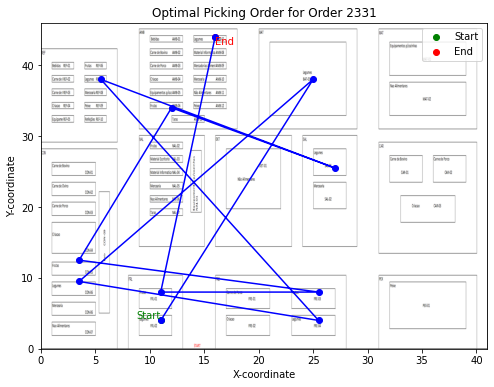

In [42]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

alley_order = optimal_order

# Retrieve the coordinates for each alley in the optimal picking order
alley_coords = []

for alley in alley_order:
    coords = s.loc[s['alley'] == alley, ['x', 'y']].values[0]
    alley_coords.append(coords)

alley_coords = np.array(alley_coords)

# Create a line plot
plt.figure(figsize=(8, 6))
plt.plot(alley_coords[:, 0], alley_coords[:, 1], marker='o', linestyle='-', color='b')
plt.scatter(alley_coords[0, 0], alley_coords[0, 1], marker='o', color='green', label='Start')
plt.scatter(alley_coords[-1, 0], alley_coords[-1, 1], marker='o', color='red', label='End')

# Load the background image
bg_image = mpimg.imread('Planta.png')  # Replace with your image path


for i, alley_coord in enumerate(alley_coords):
    if i == 0:
        plt.text(alley_coord[0], alley_coord[1], "Start", ha='right', va='bottom', color='green')
    elif i == len(alley_coords) - 1:
        plt.text(alley_coord[0], alley_coord[1], "End", ha='left', va='top', color='red')


plt.xlabel('X-coordinate')
plt.ylabel('Y-coordinate')
plt.title('Optimal Picking Order for Order 2331')
#plt.grid(True)
plt.legend()
plt.imshow(bg_image, aspect='auto', extent=(0, 41, 0, 46))
plt.show()

### Everything in fuctions

After applying the Q-learning algorithm, it is essential to evaluate the performance of the learned policy using various metrics that align with the specific problem and the goals of the reinforcement learning agent. Evaluating the performance helps determine how well the agent is performing and whether the learned policy is effective. Here are some common metrics used to evaluate Q-learning:

Cumulative reward: This metric measures the total sum of rewards obtained by the agent over time while following the learned policy. A higher cumulative reward generally indicates better performance. Comparing cumulative rewards across different policies or algorithms can help identify which performs better in terms of maximizing rewards.

Average reward: This metric calculates the mean of the rewards received by the agent over time while following the learned policy. It provides a measure of the agent's average performance and can be particularly useful when the length of episodes varies. Monitoring the average reward helps assess the consistency of the agent's performance.

Episode length: This metric quantifies the number of steps or actions the agent takes to reach a terminal state (e.g., achieving a goal) within an episode. In tasks where reaching the goal quickly is important, a shorter episode length indicates better performance. Monitoring episode length helps evaluate the agent's efficiency in accomplishing its objectives.

Success rate: This metric is applicable to goal-oriented tasks and measures the proportion of episodes in which the agent successfully reaches the desired goal while following the learned policy. A higher success rate indicates better performance. Evaluating the success rate provides insights into the effectiveness of the learned policy in achieving the desired outcomes.

Convergence time: This metric assesses the time or number of iterations required for the Q-learning algorithm to converge to a stable and optimal policy. Faster convergence indicates a more efficient learning process. Monitoring convergence time helps understand the learning dynamics and efficiency of the algorithm.

Learning curves: Visualizing the performance metrics (such as cumulative reward, average reward, success rate) over time or the number of training episodes allows for a comprehensive understanding of the learning process. Learning curves provide insights into the stability and effectiveness of the learned policy, highlighting any convergence or performance trends.

It is important to select the evaluation metrics that align with the specific objectives of the reinforcement learning agent and the problem at hand. In some cases, combining multiple metrics can provide a more comprehensive assessment of the agent's performance. Furthermore, evaluating the learned policy using test episodes or separate validation environments can help gauge the generalization and robustness of the policy beyond the training environment. Comparisons with other reinforcement learning algorithms or human expert performance can also provide valuable insights into the relative performance of the Q-learning agent.

In [43]:
import numpy as np
import pandas as pd
import time
import math

def q_learning(alpha, gamma, epsilon, n_episodes, test):
    start_time = time.time()

    # Function for calculating distance between zones
    def calculate_distance(zone1, zone2):
        x1, y1 = float(s[s["alley"] == zone1]["x"].iloc[0]), float(s[s["alley"] == zone1]["y"].iloc[0])
        x2, y2 = float(s[s["alley"] == zone2]["x"].iloc[0]), float(s[s["alley"] == zone2]["y"].iloc[0])
        distance = math.sqrt((x2 - x1)**2 + (y2 - y1)**2)
        return distance

    def get_shortest_distance_zone(zone_list):
        distances = []
        for zone in zone_list:
            distances.append(calculate_distance("START", zone))
        return zone_list[np.argmin(distances)]

    # Get the unique order ids and zones
    order_ids = test['order_id'].unique()
    zones = test['alley'].unique()
    min_order_id = np.min(order_ids)

    # Initialize the Q-table
    num_zones = len(order_ids)
    q_table = np.zeros((len(order_ids), len(zones), len(zones)))

    for episode in range(n_episodes):
        for order_id in order_ids:
            order = test[test['order_id'] == order_id]
            zone_list = order['alley'].tolist()

            for i in range(len(zone_list) - 1):
                current_zone = zone_list[i]
                next_zone = zone_list[i + 1]

                current_zone_idx = np.where(zones == current_zone)[0][0]
                next_zone_idx = np.where(zones == next_zone)[0][0]

                # Choose action (next zone) using epsilon-greedy strategy
                if np.random.random() < epsilon:
                    action_idx = np.random.randint(num_zones)
                else:
                    action_idx = np.argmax(q_table[order_id - min_order_id, current_zone_idx, :])

                # Calculate the reward based on the distance to the chosen zone
                reward = -calculate_distance(current_zone, zones[min(action_idx, len(zones)-1)])

                # Update Q-table
                q_table[order_id - min_order_id, current_zone_idx, min(action_idx, len(zones)-1)] = q_table[order_id - min_order_id, current_zone_idx, min(action_idx, len(zones)-1)] + alpha * (reward + gamma * np.max(q_table[order_id - min_order_id, min(action_idx, len(zones)-1), :]) - q_table[order_id - min_order_id, current_zone_idx, min(action_idx, len(zones)-1)])
    
    # Initialize the optimal_orders dictionary
    optimal_orders = {}
    cumulative_rewards = {}
    episode_lengths = {}
    
    # Print the optimal picking order
    for order_id in order_ids:
        order = test[test['order_id'] == order_id]
        zone_list = order['alley'].tolist()

        first_zone = get_shortest_distance_zone(zone_list)
        optimal_order = [first_zone]
        step_count = 0
        for i in range(len(zone_list) - 1):
            current_zone = zone_list[i + 1]
            current_zone_idx = np.where(zones == current_zone)[0][0]

            # Choose the best action based on the Q-table
            action_idx = np.argmax(q_table[order_id - min_order_id, current_zone_idx, :])

            if zones[action_idx] not in optimal_order:
                optimal_order.append(zones[action_idx])
                step_count += 1
    
    optimal_orders[order_id] = optimal_order
    
    # Calculate the cumulative reward for the current order_id
    cumulative_reward = 0
    for i in range(len(optimal_order) - 1):
        cumulative_reward += -calculate_distance(optimal_order[i], optimal_order[i + 1])
    cumulative_rewards[order_id] = cumulative_reward

    episode_lengths[order_id] = step_count
    
    end_time = time.time()
    print("Running time:", end_time - start_time, "seconds")    

    # Return the optimal_orders, cumulative_rewards, and episode_lengths dictionaries
    return optimal_orders, cumulative_rewards, episode_lengths

/Users/rodrigosimoes/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


The purpose of this function **optimize_parameters** is to find the optimal set of parameters for the Q-learning algorithm. It does this by systematically iterating over different combinations of parameter values and evaluating the performance of the Q-learning algorithm using a scoring criteria (average total distance in this case).

The code takes in a dataset (test) and a range of values for the Q-learning parameters (alphas, gammas, epsilons, n_episodes_list). It then performs a nested loop to iterate over all possible combinations of these parameter values.

For each combination of parameters, the Q-learning algorithm is executed using the specified parameters and the dataset. The resulting optimal picking orders are evaluated based on the scoring criteria (average total distance). The code keeps track of the best parameter combination found so far, along with the corresponding optimal picking orders and the score achieved.

By iterating through all the parameter combinations and evaluating their performance, the code identifies the parameter set that produces the best results according to the scoring criteria. The purpose is to find the parameter values that lead to the most efficient and effective learning of the Q-learning algorithm for the given problem.

In [44]:
def optimize_parameters(test, alphas, gammas, epsilons, n_episodes_list):
    best_parameters = None
    best_optimal_orders = None
    best_score = float('inf')

    for alpha, gamma, epsilon, n_episodes in itertools.product(alphas, gammas, epsilons, n_episodes_list):
        optimal_orders, _, _ = q_learning(alpha, gamma, epsilon, n_episodes, test)  # Unpack the tuple and ignore the cumulative_rewards

        # Evaluate the optimal picking orders based on some scoring criteria
        # For this example, I'll use the average total distance
        total_distance = 0
        for order_id, order_zones in optimal_orders.items():
            for i in range(len(order_zones) - 1):
                total_distance += calculate_distance(order_zones[i], order_zones[i + 1])
        avg_distance = total_distance / len(optimal_orders)

        if avg_distance < best_score:
            best_score = avg_distance
            best_parameters = (alpha, gamma, epsilon, n_episodes)
            best_optimal_orders = optimal_orders

    return best_parameters, best_optimal_orders

/Users/rodrigosimoes/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


The purpose of this function **calculate_rewards** is to provide a quantitative measure of the rewards obtained by the Q-learning algorithm. It allows for an assessment of the overall performance of the algorithm based on the cumulative rewards and provides an average measure to understand the average reward per order.

In [45]:
def calculate_rewards(optimal_orders, cumulative_rewards):
    total_reward = sum(cumulative_rewards.values())
    average_reward = total_reward / len(cumulative_rewards)
    
    return total_reward, average_reward

/Users/rodrigosimoes/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


The purpose of this function **calculate_episode_lengths** is to provide a quantitative measure of the episode lengths observed during the execution of the Q-learning algorithm. It allows for an assessment of the average number of steps taken per episode, providing insights into the efficiency or duration of the learning process.

In [46]:
def calculate_episode_lengths(episode_lengths):
    total_length = sum(episode_lengths.values())
    average_length = total_length / len(episode_lengths)

    return total_length, average_length

/Users/rodrigosimoes/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


The purpose of this functions **calculate_total_distance** and **calculate_distance_improvements** is to evaluate the effectiveness of the Q-learning algorithm by quantifying the improvement in distance traveled between the original and optimal orders. It provides insights into how well the algorithm has learned to optimize the order of zones and reduce the overall distance traveled.

In [47]:
def calculate_total_distance(order_zones):
    total_distance = 0
    for i in range(len(order_zones) - 1):
        total_distance += calculate_distance(order_zones[i], order_zones[i + 1])
    return total_distance

def calculate_distance_improvements(optimal_orders, test):
    distance_improvements = []

    order_ids = test['order_id'].unique()

    for order_id in order_ids:
        order = test[test['order_id'] == order_id]
        zone_list = order['alley'].tolist()

        # Calculate the total distance for the original order
        original_distance = calculate_total_distance(zone_list)

        # Calculate the total distance for the optimal order
        optimal_order = optimal_orders[order_id]
        optimal_distance = calculate_total_distance(optimal_order)

        improvement = original_distance - optimal_distance
        distance_improvements.append(improvement)

        print(f"Total distance for original order {order_id}: {original_distance}")
        print(f"Total distance for optimal order {order_id}: {optimal_distance}")
        print(f"Distance improvement: {improvement}")

    average_improvement = sum(distance_improvements) / len(distance_improvements)
    print(f"Average improvement in distance traveled: {average_improvement}")

/Users/rodrigosimoes/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [49]:
import itertools

# Example usage:
alphas = [0.1]#, 0.5, 0.9]
gammas = [0.99]#, 0.9, 0.8]
epsilons = [0.1]#, 0.05, 0.01]
n_episodes_list = [10]#, 100, 1000]

best_parameters, best_optimal_orders = optimize_parameters(test, alphas, gammas, epsilons, n_episodes_list)
print("Best parameters:", best_parameters)
print("Best optimal picking orders:", best_optimal_orders)

optimal_orders, cumulative_rewards, episode_length = q_learning(alpha, gamma, epsilon, n_episodes, test)
total_reward, average_reward = calculate_rewards(optimal_orders, cumulative_rewards)
print("Total cumulative reward:", total_reward)
print("Average reward:", average_reward)

# Example usage:
optimal_orders, cumulative_rewards, episode_lengths = q_learning(alpha, gamma, epsilon, n_episodes, test)
total_length, average_length = calculate_episode_lengths(episode_lengths)
print("Total episode length:", total_length)
print("Average episode length:", average_length)    

# Example usage:
optimal_orders, _, _= q_learning(alpha, gamma, epsilon, n_episodes, test)
calculate_distance_improvements(optimal_orders, test)

/Users/rodrigosimoes/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Running time: 0.414262056350708 seconds
Best parameters: (0.1, 0.99, 0.1, 10)
Best optimal picking orders: {2331: ['FRL-02', 'BAT-01', 'CON-06', 'FRE-04', 'REF-07', 'SAL-01', 'AMB-06', 'CON-05', 'FRE-03', 'FRL-01', 'AMB-07']}
Running time: 0.389570951461792 seconds
Total cumulative reward: -273.1238706524877
Average reward: -273.1238706524877
Running time: 0.366239070892334 seconds
Total episode length: 10
Average episode length: 10.0
Running time: 0.3755810260772705 seconds
Total distance for original order 2331: 408.23516875646044
Total distance for optimal order 2331: 244.91478692187002
Distance improvement: 163.32038183459042
Average improvement in distance traveled: 163.32038183459042


## Neural Network Model

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define the neural network model
class PickingOrderModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(PickingOrderModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x


# Prepare the dataset
# Make sure to include any necessary preprocessing steps for your dataset
train_data = []
train_labels = []

for order_id in order_ids:
    order = test[test['order_id'] == order_id]
    zone_coords = []

    for zone in order['alley']:
        x, y = float(s[s["alley"] == zone]["x"].iloc[0]), float(s[s["alley"] == zone]["y"].iloc[0])
        zone_coords.append([x, y])

    train_data.append(zone_coords[:-1])  # Exclude the last zone as input
    train_labels.append(zone_coords[1:])  # Exclude the first zone as output

train_data = torch.tensor(train_data, dtype=torch.float32)
train_labels = torch.tensor(train_labels, dtype=torch.float32)

# Initialize the model, loss function, and optimizer
input_size = 2
hidden_size = 10
output_size = 2

model = PickingOrderModel(input_size, hidden_size, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Train the neural network
n_epochs = 5000

for epoch in range(n_epochs):
    optimizer.zero_grad()
    outputs = model(train_data)
    loss = criterion(outputs, train_labels)
    loss.backward()
    optimizer.step()

    if epoch % 500 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")

# Include your calculate_distance, get_shortest_distance_zone, and calculate_total_distance functions
# Function for calculating distance between zones
def calculate_distance(zone1, zone2):
    x1, y1 = float(s[s["alley"] == zone1]["x"].iloc[0]), float(s[s["alley"] == zone1]["y"].iloc[0])
    x2, y2 = float(s[s["alley"] == zone2]["x"].iloc[0]), float(s[s["alley"] == zone2]["y"].iloc[0])
    distance = math.sqrt((x2 - x1)**2 + (y2 - y1)**2)
    return distance

def get_shortest_distance_zone(zone_list):
    distances = []
    for zone in zone_list:
        distances.append(calculate_distance("START", zone))
    return zone_list[np.argmin(distances)]

def calculate_total_distance(order_zones):
    total_distance = 0
    for i in range(len(order_zones) - 1):
        total_distance += calculate_distance(order_zones[i], order_zones[i + 1])
    return total_distance

# Predict the optimal picking order and calculate the total distance
for order_id in order_ids:
    order = test[test['order_id'] == order_id]
    zone_list = order['alley'].tolist()

    first_zone = get_shortest_distance_zone(zone_list)
    optimal_order = [first_zone]
    remaining_zones = [zone for zone in zone_list if zone != first_zone]

    threshold = 100

    while remaining_zones:
        current_zone = optimal_order[-1]
        x, y = float(s[s["alley"] == current_zone]["x"].iloc[0]), float(s[s["alley"] == current_zone]["y"].iloc[0])
        current_zone_coords = torch.tensor([[x, y]], dtype=torch.float32)

        # Predict the next zone coordinates
        with torch.no_grad():
            next_zone_coords = model(current_zone_coords).numpy().flatten()

        # Find the closest zone to the predicted coordinates
        closest_zone = None
        min_distance = float("inf")

        for zone in remaining_zones:
            x, y = float(s[s["alley"] == zone]["x"].iloc[0]), float(s[s["alley"] == zone]["y"].iloc[0])
            distance = np.sqrt((x - next_zone_coords[0])**2 + (y - next_zone_coords[1])**2)

            # Add an extra condition to exclude zones that have already been added to the optimal_order list
            if distance < min_distance and zone not in optimal_order:
                min_distance = distance
                closest_zone = zone

        if min_distance < threshold:
            optimal_order.append(closest_zone)
            remaining_zones.remove(closest_zone)
        else:
            break



    print(f"Optimal picking order for order {order_id}: {optimal_order}")

    total_distance = calculate_total_distance(optimal_order)
    print(f"Total distance for order {order_id}: {total_distance}")

    original_order = test[test['order_id'] == order_id]['alley'].tolist()
    original_distance = calculate_total_distance(original_order)
    print(f"Original distance for order {order_id}: {original_distance}")

    improvement = (original_distance - total_distance) / original_distance * 100
    print(f"Improvement percentage for order {order_id}: {improvement}%\n")

### Visualizing results

In [ ]:
alley_order = optimal_order

# Retrieve the coordinates for each alley in the optimal picking order
alley_coords = []

for alley in alley_order:
    coords = s.loc[s['alley'] == alley, ['x', 'y']].values[0]
    alley_coords.append(coords)

alley_coords = np.array(alley_coords)

# Create a line plot
plt.figure(figsize=(8, 6))
plt.plot(alley_coords[:, 0], alley_coords[:, 1], marker='o', linestyle='-', color='b')
plt.scatter(alley_coords[0, 0], alley_coords[0, 1], marker='o', color='green', label='Start')
plt.scatter(alley_coords[-1, 0], alley_coords[-1, 1], marker='o', color='red', label='End')

# Load the background image
bg_image = mpimg.imread('Planta.png')  # Replace with your image path

# Add alley labels
for i, alley_coord in enumerate(alley_coords):
    plt.text(alley_coord[0], alley_coord[1], f"{alley_order[i]}", ha='right', va='bottom', color='black')

# Add start and end labels
plt.text(alley_coords[0, 0], alley_coords[0, 1], "Start", ha='right', va='bottom', color='green')
plt.text(alley_coords[-1, 0], alley_coords[-1, 1], "End", ha='left', va='top', color='red')

plt.xlabel('X-coordinate')
plt.ylabel('Y-coordinate')
plt.title('Optimal Picking Order for Order 2331')
#plt.grid(True)
plt.legend()
plt.imshow(bg_image, aspect='auto', extent=(0, 41, 0, 46))
plt.show()